Carbon Insight: Carbon Emissions Visualization
==============================================

This tutorial aims to showcase how to visualize anthropogenic CO2 emissions with a near-global coverage and track correlations between global carbon emissions and socioeconomic factors such as COVID-19 and GDP.

In [1]:
# Requirements
%pip install numpy
%pip install pandas
%pip install matplotlib


# A. Process Carbon Emission Data

This notebook helps you to process and visualize carbon emission data provided by [Carbon-Monitor](https://carbonmonitor.org/), which records human-caused carbon emissions from different countries, sources, and timeframes that are of interest to you.

Overview:
- [Process carbon emission data](#a1)
  - [Download data from Carbon Monitor](#a11)
  - [Calculate the rate of change](#a12)
  - [Expand country regions](#a13)
- [Visualize carbon emission data](#a2)
  - [Observe carbon emission data from the perspective of time](#a21)
  - [Compare carbon emission data of different sectors](#a22)
- [Examples](#a3)
  - [World carbon emission data](#a31)
  - [US carbon emission data](#a32)

In [2]:
import io
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


In [3]:
import os

# Optional Function: Export Data
def export_data(file_name: str, df: pd.DataFrame):
    # df = country_region_name_to_code(df)
    export_path = os.path.join('export_data', file_name)
    print(f'Export Data to {export_path}')
    if not os.path.exists('export_data'):
        os.mkdir('export_data')
    with open(export_path, 'w', encoding='utf-8') as f:
        f.write(df.to_csv(index=None, line_terminator='\n', encoding='utf-8'))


## <a id="a1"></a> 1. Process Data

### <a id="a11"></a> 1.1. Download data from Carbon Monitor
We are going to download tabular carbon emission data and convert to Pandas Dataframe.

Supported data types:

- ```carbon_global``` includes carbon emission data of 11 countries and regions worldwide.
- ```carbon_us``` includes carbon emission data of 51 states of the United States.
- ```carbon_eu``` includes carbon emission data of 27 countries of the European Union.
- ```carbon_china``` includes carbon emission data of 31 cities and provinces of China.

In [4]:
def get_data_from_carbon_monitor(data_type='carbon_global'):
    assert data_type in ['carbon_global', 'carbon_us', 'carbon_eu', 'carbon_china']
    data_url = f'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source={data_type}'
    data = urlopen(data_url).read().decode('utf-8-sig')
    df = pd.read_csv(io.StringIO(data))
    df = df.drop(columns=['timestamp'])
    df = df.loc[pd.notna(df['date'])]
    df = df.rename(columns={'country': 'country_region'})
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    if data_type == 'carbon_us':
        df = df.loc[df['state'] != 'United States']
    return df

### <a id="a12"></a> 1.2. Calculate the rate of change
The rate of change $\Delta(s, r, t)$ is defined as the ratio of current value and moving average of a certain window size:
$$\begin{aligned}
\Delta(s, r, t) = \left\{\begin{aligned}
&\frac{TX(s, r, t)}{\sum_{\tau=t-T}^{t-1}X(\tau)}, &t\geq T\\
&1, &0<t<T
\end{aligned}\right.
\end{aligned}$$
Where $X(s, r, t)$ is the carbon emission value of sector $s$, region $r$ and date $t$; $T$ is the window size with default value $T=14$.

In [5]:
def calculate_rate_of_change(df, window_size=14):
    region_scope = 'state' if 'state' in df.columns else 'country_region'
    new_df = pd.DataFrame()
    for sector in set(df['sector']):
        sector_mask = df['sector'] == sector
        for region, values in df.loc[sector_mask].pivot(index='date', columns=region_scope, values='value').items():
            values.fillna(0)
            rates = values / values.rolling(window_size).mean()
            rates.fillna(value=1, inplace=True)
            tmp_df = pd.DataFrame(
                index=values.index,
                columns=['value', 'rate_of_change'],
                data=np.array([values.to_numpy(), rates.to_numpy()]).T
            )
            tmp_df['sector'] = sector
            tmp_df[region_scope] = region
            new_df = new_df.append(tmp_df.reset_index())
    return new_df

### <a id="a13"></a> 1.3. Expand country regions
*Note: This step applies only to the ```carbon_global``` dataset.*

The dataset ```carbon_global``` does not list all the countries/regions in the world. Instead, there are two groups which contains multiple countries/regions: ```ROW``` (i.e. the rest of the world) and ```EU27 & UK```.

In order to obtain the carbon emission data of countries/regions in these two groups, we can refer to [the EDGAR dataset](https://edgar.jrc.ec.europa.eu/dataset_ghg60) and use [the table of CO2 emissions of all world countries in 2019](./static_data/Baseline.csv) as the baseline.

Assume the the carbon emission of each non-listed country/region is linearly related to the carbon emission of the group it belongs to, we have:
$$\begin{aligned}
X(s, r, t) &= \frac{\sum_{r_i\in R(r)}X(s, r_i, t)}{\sum_{r_i\in R(r)}X(s, r_i, t_0)}X(s, r, t_0)\\
&= \frac{X_{Raw}(s, R(r), t)}{\sum_{r_i\in R(r)}X_{Baseline}(s, r_i)}X_{Baseline}(s, r)
\end{aligned}$$
Where
- $X(s, r, t)$ is the carbon emission value of sector $s$, country/region $r$ and date $t$.
- $t_0$ is the date of the baseline table.
- $R(r)$ is the group that contains country/region $r$.
- $X_{Raw}(s, R, t)$ is the carbon emission value of sector $s$, country/region group $R$ and date $t$ in the ```carbon_global``` dataset.
- $X_{Baseline}(s, r)$ is the carbon emission value of sector $s$ and country/region $r$ in the baseline table.

Note that the baseline table does not contain the ```International Aviation``` sector. Therefore, the data for ```International Aviation``` is only available to countries listed in the ```carbon_global``` dataset. When we expand the ```ROW``` and the ```EU27 & UK``` groups to other countries/regions of the world, only the other five sectors are considered.

In [6]:
def expand_country_regions(df):

    sectors = set(df['sector'])
    assert 'country_region' in df.columns
    df = df.replace('US', 'United States')
    df = df.replace('UK', 'United Kingdom')
    original_country_regions = set(df['country_region'])

    country_region_df = pd.read_csv('static_data/CountryRegion.csv')
    base = {}
    name_to_code = {}
    for _, (name, code, source) in country_region_df.loc[:, ['Name', 'Code', 'DataSource']].iterrows():
        if source.startswith('Simulated') and name not in original_country_regions:
            name_to_code[name] = code
            base[code] = 'ROW' if source.endswith('ROW') else 'EU27 & UK'

    baseline = pd.read_csv('static_data/Baseline.csv')
    baseline = baseline.set_index('CountryRegionCode')
    baseline = baseline.loc[:, [sector for sector in baseline.columns if sector in sectors]]
    group_baseline = {}
    for group in original_country_regions & set(['ROW', 'EU27 & UK']):
        group_baseline[group] = baseline.loc[[code for code, base_group in base.items() if base_group == group], :].sum()

    new_df = pd.DataFrame()
    sector_masks = {sector: df['sector'] == sector for sector in sectors}
    for country_region in set(country_region_df['Name']):
        if country_region in name_to_code:
            code = name_to_code[country_region]
            group = base[code]
            group_mask = df['country_region'] == group
            for sector, sum_value in group_baseline[group].items():
                tmp_df = df.loc[sector_masks[sector] & group_mask, :].copy()
                tmp_df['value'] = tmp_df['value'] / sum_value * baseline.loc[code, sector]
                tmp_df['country_region'] = country_region
                new_df = new_df.append(tmp_df)
        elif country_region in original_country_regions:
            new_df = new_df.append(df.loc[df['country_region'] == country_region])

    return new_df


## 2. <a id="a2"></a> Visualize Data
This is a auxiliary module for displaying data, which can be modified arbitrarily.

### <a id="a21"></a> 2.1. Plot by date
In this part we are going to create a line chart, where the emission value and rate of change for given counties during the given time can be browsed.

In [7]:
def plot_by_date(df, start_date=None, end_date=None, sector=None, regions=None, title='Carbon Emission by Date'):
    if start_date is None:
        start_date = df['date'].min()
    if end_date is None:
        end_date = df['date'].max()
    tmp_df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]

    region_scope = 'state' if 'state' in tmp_df.columns else 'country_region'
    if regions is None or type(regions) == int:
        region_list = list(set(tmp_df[region_scope]))
        sector_mask = True if sector is None else tmp_df['sector'] == sector
        region_list.sort(key=lambda region: -tmp_df.loc[(tmp_df[region_scope] == region) & sector_mask, 'value'].sum())
        regions = region_list[:3 if regions is None else regions]
    tmp_df = pd.concat([tmp_df.loc[tmp_df[region_scope] == region] for region in regions])

    if sector not in set(tmp_df['sector']):
        tmp_df['rate_of_change'] = tmp_df['value'] / tmp_df['rate_of_change']
        tmp_df = tmp_df.groupby(['date', region_scope]).sum().reset_index()
        value_df = tmp_df.pivot(index='date', columns=region_scope, values='value')
        rate_df = tmp_df.pivot(index='date', columns=region_scope, values='rate_of_change')
        rate_df = value_df / rate_df
    else:
        tmp_df = tmp_df.loc[tmp_df['sector'] == sector, [region_scope, 'date', 'value', 'rate_of_change']]
        value_df = tmp_df.pivot(index='date', columns=region_scope, values='value')
        rate_df = tmp_df.pivot(index='date', columns=region_scope, values='rate_of_change')
    value_df = value_df.loc[:, regions]
    rate_df = rate_df.loc[:, regions]

    fig = plt.figure(figsize=(10, 8))
    fig.suptitle(title)

    plt.subplot(2, 1, 1)
    plt.plot(value_df)
    plt.ylabel('Carbon Emission Value / Mt CO2')
    plt.xticks(rotation=60)
    plt.legend(regions, loc='upper right')

    plt.subplot(2, 1, 2)
    plt.plot(rate_df)
    plt.ylabel('Rate of Change')
    plt.xticks(rotation=60)
    plt.legend(regions, loc='upper right')

    plt.subplots_adjust(hspace=0.3)


### <a id="a22"></a> 2.2. Plot by sector
Generally, sources of emissions can be divided into five or six categories:
- Domestic Aviation
- Ground Transport
- Industry
- Power 
- Residential
- International Aviation

Where the data of ```International Aviation``` are only available to ```carbon_global``` and ```carbon_us``` datasets. For ```carbon_global``` dataset, we can not expand the data for International Aviation of non-listed countries.

Let's create a pie chart and a stacked column chart, where you can focus on details of specific countiy/regions’ emission data, including quantity and percentage breakdown by above sectors. 

In [8]:
def plot_by_sector(df, start_date=None, end_date=None, sectors=None, region=None, title='Carbon Emission Data by Sector'):
    if start_date is None:
        start_date = df['date'].min()
    if end_date is None:
        end_date = df['date'].max()
    tmp_df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]

    region_scope = 'state' if 'state' in df.columns else 'country_region'
    if region in set(tmp_df[region_scope]):
        tmp_df = tmp_df.loc[tmp_df[region_scope] == region]

    if sectors is None:
        sectors = list(set(tmp_df['sector']))
    sectors.sort(key=lambda sector: -tmp_df.loc[tmp_df['sector'] == sector, 'value'].sum())
    tmp_df = tmp_df.loc[[sector in sectors for sector in tmp_df['sector']]]

    fig = plt.figure(figsize=(10, 8))
    fig.suptitle(title)

    plt.subplot(2, 1, 1)
    data = np.array([tmp_df.loc[tmp_df['sector'] == sector, 'value'].sum() for sector in sectors])
    total = tmp_df['value'].sum()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")
    wedges, texts = plt.pie(data, wedgeprops=dict(width=0.5), startangle=90)
    for i, p in enumerate(wedges):
        factor = data[i] / total * 100
        if factor > 5:
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            text = '{}\n{:.1f} Mt CO2 ({:.1f}%)'.format(sectors[i], data[i], factor)
            plt.annotate(
                text,
                xy=(x, y),
                xytext=(1.35 * np.sign(x), 1.4 * y),
                horizontalalignment=horizontalalignment,
                **kw
            )
    plt.axis('equal')

    plt.subplot(2, 1, 2)
    labels = []
    data = [[] for _ in sectors]
    date =  pd.to_datetime(start_date)
    delta = pd.DateOffset(months=1)
    while date <= pd.to_datetime(end_date):
        sub_df = tmp_df.loc[(tmp_df['date'] >= date) & (tmp_df['date'] < date + delta)]
        for i, sector in enumerate(sectors):
            data[i].append(sub_df.loc[sub_df['sector'] == sector, 'value'].sum())
        labels.append(date.strftime('%Y-%m'))
        date += delta
    data = np.array(data)
    for i, sector in enumerate(sectors):
        plt.bar(labels, data[i], bottom=data[:i].sum(axis=0), label=sector)
    plt.xticks(rotation=60)
    plt.legend()


## <a id="a3"></a> 3. Examples

### <a id="a31"></a> 3.1. World carbon emission data

In [9]:
data_type = 'carbon_global'
print(f'Download {data_type} data')
global_df = get_data_from_carbon_monitor(data_type)
print('Calculate rate of change')
global_df = calculate_rate_of_change(global_df)
print('Expand country / regions')
global_df = expand_country_regions(global_df)

export_data('global_carbon_emission_data.csv', global_df)
global_df

Download carbon_global data
Calculate rate of change
Expand country / regions
Export Data to export_data\global_carbon_emission_data.csv


,date,value,rate_of_change,sector,country_region
0,2019-01-01,0.112941,1.000000,Power,Montenegro
1,2019-01-02,0.120552,1.000000,Power,Montenegro
2,2019-01-03,0.126057,1.000000,Power,Montenegro
3,2019-01-04,0.132794,1.000000,Power,Montenegro
4,2019-01-05,0.129115,1.000000,Power,Montenegro
...,...,...,...,...,...
1091,2021-12-27,0.010651,0.970426,Residential,Estonia
1092,2021-12-28,0.009503,0.868008,Residential,Estonia
1093,2021-12-29,0.008750,0.802686,Residential,Estonia
1094,2021-12-30,0.007343,0.683108,Residential,Estonia


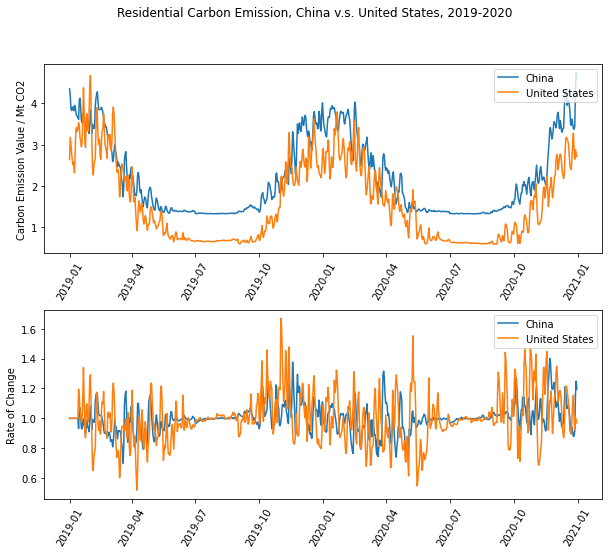

In [10]:
plot_by_date(
    global_df,
    start_date='2019-01-01',
    end_date='2020-12-31',
    sector='Residential',
    regions=['China', 'United States'],
    title='Residential Carbon Emission, China v.s. United States, 2019-2020'
)

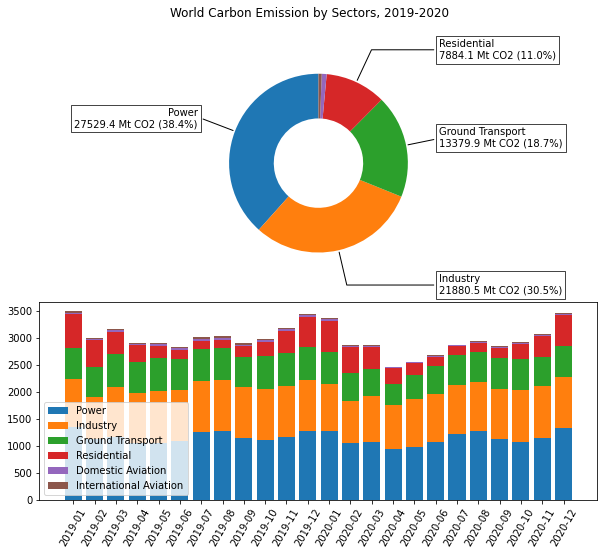

In [11]:
plot_by_sector(
    global_df,
    start_date='2019-01-01',
    end_date='2020-12-31',
    sectors=None,
    region=None,
    title='World Carbon Emission by Sectors, 2019-2020',
)

### <a id="a32"></a> 3.2. US carbon emission data

In [12]:
data_type = 'carbon_us'
print(f'Download {data_type} data')
us_df = get_data_from_carbon_monitor(data_type)
print('Calculate rate of change')
us_df = calculate_rate_of_change(us_df)
export_data('us_carbon_emission_data.csv', us_df)
us_df

Download carbon_us data
Calculate rate of change
Export Data to export_data\us_carbon_emission_data.csv


,date,value,rate_of_change,sector,state
0,2019-01-01,9.917140e-02,1.000000,Power,Alabama
1,2019-01-02,1.142040e-01,1.000000,Power,Alabama
2,2019-01-03,1.180630e-01,1.000000,Power,Alabama
3,2019-01-04,1.091590e-01,1.000000,Power,Alabama
4,2019-01-05,1.003130e-01,1.000000,Power,Alabama
...,...,...,...,...,...
1091,2021-12-27,2.490000e-05,2.234615,International Aviation,Wyoming
1092,2021-12-28,0.000000e+00,0.000000,International Aviation,Wyoming
1093,2021-12-29,5.000000e-07,0.053805,International Aviation,Wyoming
1094,2021-12-30,1.750000e-05,1.670075,International Aviation,Wyoming


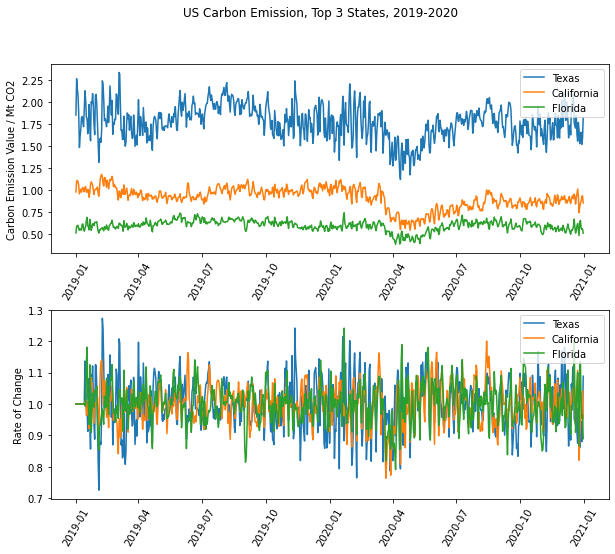

In [13]:
plot_by_date(
    us_df,
    start_date='2019-01-01',
    end_date='2020-12-31',
    sector=None,
    regions=3,
    title='US Carbon Emission, Top 3 States, 2019-2020'
)


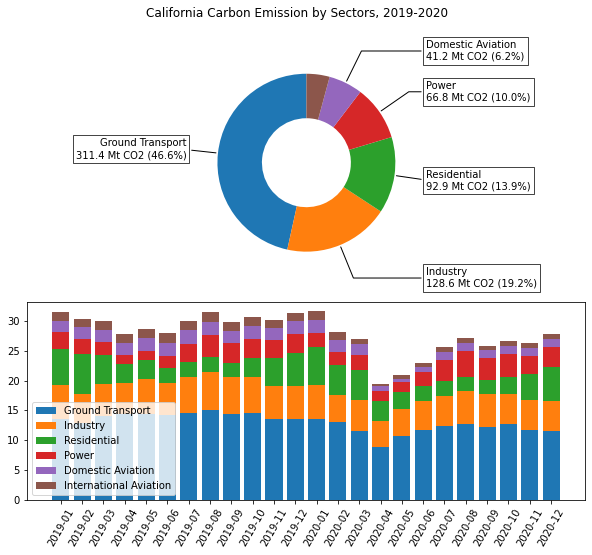

In [14]:
plot_by_sector(
    us_df,
    start_date='2019-01-01',
    end_date='2020-12-31',
    sectors = None,
    region='California',
    title='California Carbon Emission by Sectors, 2019-2020',
)

# B. Co-Analysis of Carbon Emission Data v.s. COVID-19 Data

This section will help you to visualize the relativity between carbon emissions in different countries and the trends of the COVID-19 pandemic since January 2020 provided by [Oxford COVID-19 Government Response Tracker](https://covidtracker.bsg.ox.ac.uk/). The severity of the epidemic can be shown in three aspects: the number of new diagnoses, the number of deaths and the stringency and policy indices of governments.

Overview:
- [Download data from Oxford COVID-19 Government Response Tracker](#b1)
- [Visualize COVID-19 data and carbon emission data](#b2)
- [Example: COVID-19 cases and stringency index v.s. carbon emission in US](#b3)

In [15]:
import json
import datetime
from urllib.request import urlopen

## 1. <a id="b1"></a> Download COVID-19 Data

We are going to download JSON-formatted COVID-19 data and convert to Pandas Dataframe. The Oxford COVID-19 Government Response Tracker dataset provides confirmed cases, deaths and stringency index data for all countries/regions since January 2020.

- The ```confirmed``` measurement records the total number of confirmed COVID-19 cases since January 2020. We will convert it into incremental data.
- The ```deaths``` measurement records the total number of patients who died due to infection with COVID-19 since January 2020. We will convert it into incremental data.
- The ```stringency``` measurement means the Stringency Index, which is a float number from 0 to 100 that reflects how strict a country’s measures were, including lockdown, school closures, travel bans, etc. A higher score indicates a stricter response (i.e. 100 = strictest response). 


In [16]:
def get_covid_data_from_oxford_covid_tracker(data_type='carbon_global'):
    data = json.loads(urlopen("https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range/{}/{}".format(
        "2020-01-22",
        datetime.datetime.now().strftime("%Y-%m-%d")
    )).read().decode('utf-8-sig'))
    country_region_df = pd.read_csv('static_data/CountryRegion.csv')
    code_to_name = {code: name for _, (name, code) in country_region_df.loc[:, ['Name', 'Code']].iterrows()}
    last_df = 0
    df = pd.DataFrame()
    for date in sorted(data['data'].keys()):
        sum_df = pd.DataFrame({name: data['data'][date][code] for code, name in code_to_name.items() if code in data['data'][date]})
        sum_df = sum_df.T[['confirmed', 'deaths', 'stringency']].fillna(last_df).astype(np.float32)
        tmp_df = sum_df - last_df
        last_df = sum_df[['confirmed', 'deaths']]
        last_df['stringency'] = 0
        tmp_df = tmp_df.reset_index().rename(columns={'index': 'country_region'})
        tmp_df['date'] = pd.to_datetime(date)
        df = df.append(tmp_df)
    return df


## <a id="b2"></a> 2. Visualize COVID-19 Data and Carbon Emission Data

This part will guide you to create a line-column chart, where you can view the specified COVID-19 measurement (```confirmed```, ```deaths``` or ```stringency```) and carbon emissions in the specified country/region throughout time. 

In [17]:
def plot_covid_data_vs_carbon_emission_data(
    covid_df, carbon_df, start_date=None, end_date=None,
    country_region=None, sector=None, covid_measurement='confirmed',
    title='Carbon Emission v.s. COVID-19 Confirmed Cases'
):
    if start_date is None:
        start_date = max(covid_df['date'].min(), carbon_df['date'].min())
    if end_date is None:
        end_date = min(covid_df['date'].max(), carbon_df['date'].max())
    x = pd.to_datetime(start_date)
    dates = [x]
    while x <= pd.to_datetime(end_date):
        x = x.replace(year=x.year+1, month=1) if x.month == 12 else x.replace(month=x.month+1)
        dates.append(x)
    dates = [f'{x.year}-{x.month}' for x in dates]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xticks(rotation=60)

    if sector in set(carbon_df['sector']):
        carbon_df = carbon_df[carbon_df['sector'] == sector]
    else:
        sector = 'All Sectors'
    if 'country_region' not in carbon_df.columns:
        raise ValueError('The carbon emission data need to be disaggregated by countries/regions.')
    if country_region in set(carbon_df['country_region']):
        carbon_df = carbon_df.loc[carbon_df['country_region'] == country_region]
    else:
        country_region = 'World'
    carbon_df = carbon_df[['date', 'value']]
    carbon_df = carbon_df.loc[(carbon_df['date'] >= f'{dates[0]}-01') & (carbon_df['date'] < f'{dates[-1]}-01')].set_index('date')
    carbon_df = carbon_df.groupby(carbon_df.index.year * 12 + carbon_df.index.month).sum()
    plt.bar(dates[:-1], carbon_df['value'], color='C1')
    plt.ylim(0)
    plt.legend([f'{country_region} {sector}\nCarbon Emission / Mt CO2'], loc='upper left')

    plt.twinx()
    if country_region in set(covid_df['country_region']):
        covid_df = covid_df.loc[covid_df['country_region'] == country_region]
    covid_df = covid_df[['date', covid_measurement]]
    covid_df = covid_df.loc[(covid_df['date'] >= f'{dates[0]}-01') & (covid_df['date'] < f'{dates[-1]}-01')].set_index('date')
    covid_df = covid_df.groupby(covid_df.index.year * 12 + covid_df.index.month)
    covid_df = covid_df.mean() if covid_measurement == 'stringency' else covid_df.sum()
    plt.plot(dates[:-1], covid_df[covid_measurement])
    plt.ylim(0, 100 if covid_measurement == 'stringency' else None)
    plt.legend([f'COVID-19\n{covid_measurement}'], loc='upper right')


## <a id="b3"></a> 3. Examples

In [18]:
print(f'Download COVID-19 data')
covid_df = get_covid_data_from_oxford_covid_tracker(data_type)
export_data('covid_data.csv', covid_df)
covid_df

Download COVID-19 data
Export Data to export_data\covid_data.csv


,country_region,confirmed,deaths,stringency,date
0,Aruba,0.0,0.0,0.000000,2020-01-22
1,Afghanistan,0.0,0.0,0.000000,2020-01-22
2,Angola,0.0,0.0,0.000000,2020-01-22
3,Albania,0.0,0.0,0.000000,2020-01-22
4,United Arab Emirates,0.0,0.0,0.000000,2020-01-22
...,...,...,...,...,...
164,Vanuatu,0.0,0.0,19.440001,2022-02-03
165,Yemen,32.0,2.0,12.040000,2022-02-03
166,South Africa,3266.0,82.0,41.669998,2022-02-03
167,Zambia,388.0,4.0,37.959999,2022-02-03


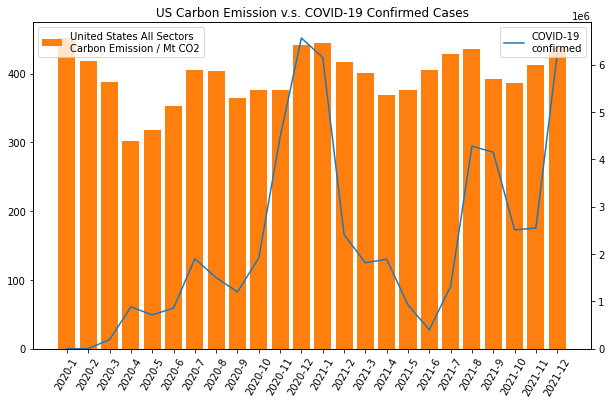

In [19]:
plot_covid_data_vs_carbon_emission_data(
    covid_df,
    global_df,
    start_date=None,
    end_date=None,
    country_region='United States',
    sector=None,
    covid_measurement='confirmed',
    title = 'US Carbon Emission v.s. COVID-19 Confirmed Cases'
)

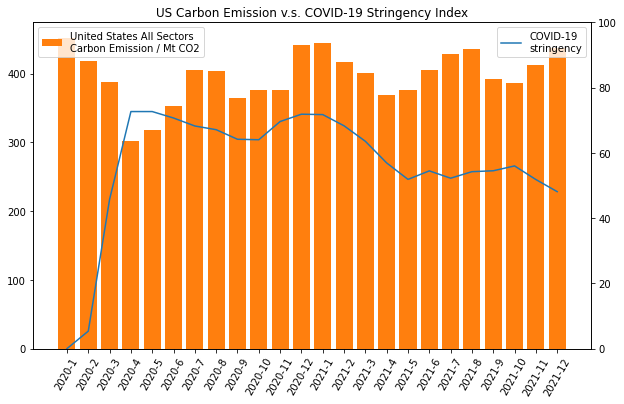

In [20]:
plot_covid_data_vs_carbon_emission_data(
    covid_df,
    global_df,
    start_date=None,
    end_date=None,
    country_region='United States',
    sector=None,
    covid_measurement='stringency',
    title = 'US Carbon Emission v.s. COVID-19 Stringency Index'
)

# C. Co-Analysis of Historical Carbon Emission Data v.s. Population & GDP Data

This section illustrates how to compare carbon intensity and per capita emissions of different countries/regions. Refer to [the EDGAR dataset](https://edgar.jrc.ec.europa.eu/dataset_ghg60) and [World Bank Open Data](https://data.worldbank.org/), carbon emissions, population and GDP data of countries/regions in the world from 1970 to 2018 are available.  

Overview:
- [Process carbon emission & social economy data](#c1)
  - [Download data from EDGAR](#c11)
  - [Download data from World Bank](#c12)
  - [Merge datasets](#c13)
- [Visualize carbon emission & social economy data](#c2)
  - [See how per capita emissions change over time in different countries/regions](#c21)
  - [Observe how *carbon intensity* reduced over time](#c22)
- [Example: relationships of carbon emission and social economy in huge countries](#c3)

*Carbon intensity* is the measure of CO2 produced per US dollar GDP. In other words, it’s a measure of how much CO2 we emit when we generate one dollar of domestic economy. A rapidly decreasing carbon intensity is beneficial for the environment and economy.

In [21]:
import zipfile


## <a id="c1"></a> 1. Process Carbon Emission & Social Economy Data

### <a id="c11"></a> 1.1. Download 1970-2018 yearly carbon emission data from the EDGAR dataset

In [22]:
def get_historical_carbon_emission_data_from_edgar():
    if not os.path.exists('download_data'):
        os.mkdir('download_data')
    site = 'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/EDGAR/datasets'
    dataset = 'v60_GHG/CO2_excl_short-cycle_org_C/v60_GHG_CO2_excl_short-cycle_org_C_1970_2018.zip'
    with open('download_data/historical_carbon_emission.zip', 'wb') as f:
        f.write(urlopen(f'{site}/{dataset}').read())
    with zipfile.ZipFile('download_data/historical_carbon_emission.zip', 'r') as zip_ref:
        zip_ref.extractall('download_data/historical_carbon_emission')
    hist_carbon_df = pd.read_excel(
        'download_data/historical_carbon_emission/v60_CO2_excl_short-cycle_org_C_1970_2018.xls',
        sheet_name='TOTALS BY COUNTRY',
        index_col=2,
        header=9,
    ).iloc[:, 4:]
    hist_carbon_df.columns = hist_carbon_df.columns.map(lambda x: pd.to_datetime(f'{x[-4:]}-01-01'))
    hist_carbon_df.index = hist_carbon_df.index.rename('country_region')
    hist_carbon_df *= 1000
    return hist_carbon_df


### <a id="c12"></a> 1.2. Download 1960-pressent yearly population and GDP data from World Bank

In [23]:
def read_worldbank_data(data_id):
    tmp_df = pd.read_excel(
        f'https://api.worldbank.org/v2/en/indicator/{data_id}?downloadformat=excel',
        sheet_name='Data',
        index_col=1,
        header=3,
    ).iloc[:, 3:]
    tmp_df.columns = tmp_df.columns.map(lambda x: pd.to_datetime(x, format='%Y'))
    tmp_df.index = tmp_df.index.rename('country_region')
    return tmp_df

def get_population_and_gdp_data_from_worldbank():
    return read_worldbank_data('SP.POP.TOTL'), read_worldbank_data('NY.GDP.MKTP.CD')


### <a id="c13"></a> 1.3. Merge the three datasets

In [24]:
def melt_table_by_years(df, value_name, country_region_codes, code_to_name, years):
    return df.loc[country_region_codes, years].rename(index=code_to_name).reset_index().melt(
        id_vars=['country_region'],
        value_vars=years,
        var_name='date',
        value_name=value_name
    )

def merge_historical_data(hist_carbon_df, pop_df, gdp_df):
    country_region_df = pd.read_csv('static_data/CountryRegion.csv')
    code_to_name = {code: name for _, (name, code) in country_region_df.loc[:, ['Name', 'Code']].iterrows()}
    country_region_codes = sorted(set(pop_df.index) & set(gdp_df.index) & set(hist_carbon_df.index) & set(code_to_name.keys()))
    years = sorted(set(pop_df.columns) & set(gdp_df.columns) & set(hist_carbon_df.columns))
    pop_df = melt_table_by_years(pop_df, 'population', country_region_codes, code_to_name, years)
    gdp_df = melt_table_by_years(gdp_df, 'gdp', country_region_codes, code_to_name, years)
    hist_carbon_df = melt_table_by_years(hist_carbon_df, 'carbon_emission', country_region_codes, code_to_name, years)
    hist_carbon_df['population'] = pop_df['population']
    hist_carbon_df['gdp'] = gdp_df['gdp']
    return hist_carbon_df.fillna(0)

## <a id="c2"></a> 2. Visualize Carbon Emission & Social Economy Data

## <a id="c21"></a> 2.1. Plot changes in per capita emissions
We now will walk you through how to plot a bubble chart of per capita GDP and per capita emissions of different countries/regions for a given year. 

In [25]:
def plot_carbon_emission_data_vs_gdp(df, year=None, countries_regions=None, title='Carbon Emission per Capita v.s. GDP per Capita'):
    if year is None:
        date = df['date'].max()
    else:
        date = min(max(pd.to_datetime(year, format='%Y'), df['date'].min()), df['date'].max())
    df = df[df['date'] == date]

    if countries_regions is None or type(countries_regions) == int:
        country_region_list = list(set(df['country_region']))
        country_region_list.sort(key=lambda country_region: -df.loc[df['country_region'] == country_region, 'population'].to_numpy())
        countries_regions = country_region_list[:10 if countries_regions is None else countries_regions]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    max_pop = df['population'].max()
    for country_region in countries_regions:
        row = df.loc[df['country_region'] == country_region]
        plt.scatter(
            x=row['gdp'] / row['population'],
            y=row['carbon_emission'] / row['population'],
            s=row['population'] / max_pop * 1000,
        )
    for lgnd in plt.legend(countries_regions).legendHandles:
        lgnd._sizes = [50]
    plt.xlabel('GDP per Capita (USD)')
    plt.ylabel('Carbon Emission per Capita (tCO2)')


## <a id="c22"></a> 2.2. Plot changes in carbon intensity
To see changes in Carbon Intensity of different countries overtime, let’s plot a line chart.

In [26]:
def plot_carbon_indensity_data(df, start_year=None, end_year=None, countries_regions=None, title='Carbon Indensity'):
    start_date = df['date'].min() if start_year is None else pd.to_datetime(start_year, format='%Y')
    end_date = df['date'].max() if end_year is None else pd.to_datetime(end_year, format='%Y')
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    if countries_regions is None or type(countries_regions) == int:
        country_region_list = list(set(df['country_region']))
        country_region_list.sort(key=lambda country_region: -df.loc[df['country_region'] == country_region, 'population'].sum())
        countries_regions = country_region_list[:3 if countries_regions is None else countries_regions]
    df = pd.concat([df[df['country_region'] == country_region] for country_region in countries_regions])
    df['carbon_indensity'] = df['carbon_emission'] / df['gdp']
    indensity_df = df.pivot(index='date', columns='country_region', values='carbon_indensity')[countries_regions]
    emission_df = df.pivot(index='date', columns='country_region', values='carbon_emission')[countries_regions]

    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.title(title)
    plt.plot(indensity_df)
    plt.legend(countries_regions)
    plt.ylabel('Carbon Emission (tCO2) per Dollar GDP')
    plt.subplot(212)
    plt.plot(emission_df)
    plt.legend(countries_regions)
    plt.ylabel('Carbon Emission (tCO2)')


## <a id="c3"></a> 3. Examples

In [27]:
print('Download historical carbon emission data')
hist_carbon_df = get_historical_carbon_emission_data_from_edgar()
print('Download population & GDP data')
pop_df, gdp_df = get_population_and_gdp_data_from_worldbank()
print('Merge data')
hist_carbon_df = merge_historical_data(hist_carbon_df, pop_df, gdp_df)
export_data('historical_carbon_emission_data.csv', hist_carbon_df)
hist_carbon_df

Download historical carbon emission data
Download population & GDP data
Merge data
Export Data to export_data\historical_carbon_emission_data.csv


,country_region,date,carbon_emission,population,gdp
0,Aruba,1970-01-01,6.903589e+04,59070.0,0.000000e+00
1,Afghanistan,1970-01-01,1.718179e+06,11173654.0,1.748887e+09
2,Angola,1970-01-01,8.952568e+06,5890360.0,0.000000e+00
3,Albania,1970-01-01,4.813550e+06,2135479.0,0.000000e+00
4,United Arab Emirates,1970-01-01,1.943758e+07,234512.0,0.000000e+00
...,...,...,...,...,...
9109,Samoa,2018-01-01,3.522141e+05,196128.0,8.212869e+08
9110,Yemen,2018-01-01,1.021375e+07,28498683.0,2.160614e+10
9111,South Africa,2018-01-01,4.580060e+08,57792520.0,4.048421e+11
9112,Zambia,2018-01-01,8.272933e+06,17351714.0,2.631159e+10


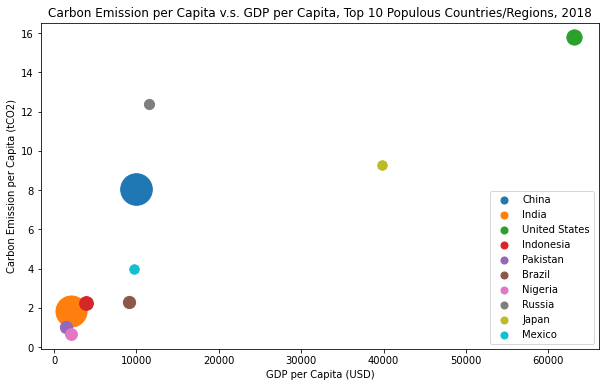

In [28]:
plot_carbon_emission_data_vs_gdp(
    hist_carbon_df,
    year=2018,
    countries_regions=10,
    title = 'Carbon Emission per Capita v.s. GDP per Capita, Top 10 Populous Countries/Regions, 2018'
)

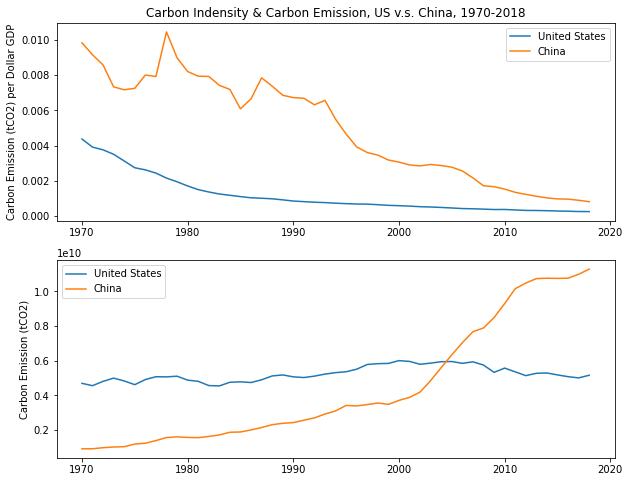

In [29]:
plot_carbon_indensity_data(
    hist_carbon_df,
    start_year=None,
    end_year=None,
    countries_regions=['United States', 'China'],
    title='Carbon Indensity & Carbon Emission, US v.s. China, 1970-2018'
)